<a href="https://colab.research.google.com/github/karaage0703/karaage-ai-book/blob/master/ch03/03_karaage_ai_book_generate_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ディープラーニングによる文章生成

ディープラーニングによる文章生成を実施します。

## 教師データのダウンロード

In [1]:
!wget https://github.com/aozorabunko/aozorabunko/raw/master/cards/000096/files/2093_ruby_28087.zip
!unzip 2093_ruby_28087.zip

--2021-09-12 15:08:55--  https://github.com/aozorabunko/aozorabunko/raw/master/cards/000096/files/2093_ruby_28087.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aozorabunko/aozorabunko/master/cards/000096/files/2093_ruby_28087.zip [following]
--2021-09-12 15:08:56--  https://raw.githubusercontent.com/aozorabunko/aozorabunko/master/cards/000096/files/2093_ruby_28087.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 421747 (412K) [application/zip]
Saving to: ‘2093_ruby_28087.zip’

2093_ruby_28087.zip 100%[===================>] 411.86K  --.-KB/s    in 0.04s   

2021-09-12 15:08:56 (9.22 MB/s

In [2]:
with open('dogura_magura.txt', encoding='shift_jis') as f:
  text = f.read()

text = text[0:20000]
print('corpus length:', len(text))

corpus length: 20000


## データの前処理

不要な文字の削除

In [3]:
import re
def normalize_text(text):
  text = re.sub(r'》', '', text)
  text = re.sub(r'※', '', text)
  text = re.sub(r'《', '', text)
  text = re.sub(r'［', '', text)
  text = re.sub(r'＃', '', text)
  text = re.sub(r'-', '', text)
  text = re.sub(r'｜', '', text)
  text = re.sub(r'］', '', text)
  text = re.sub(r'［', '', text)
  text = re.sub(r'【','', text)
  text = re.sub(r'】','', text)
  text = re.sub(r'\n', '', text)
  text = re.sub(r'\u3000', '', text)

  text = text.strip()
  return text

In [4]:
text = normalize_text(text)

In [5]:
text[0:100]

'ドグラ・マグラ夢野久作テキスト中に現れる記号について：ルビ（例）蜜蜂みつばち：ルビの付く文字列の始まりを特定する記号（例）大の字型なりに：入力者注主に外字の説明や、傍点の位置の指定（数字は、JIS X'

## 学習

必要なライブラリをインポートします

In [6]:
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

2.6.0


必要なライブラリのインポート

In [7]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
#from keras.optimizers import RMSprop 
from tensorflow.keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

import matplotlib.pyplot as plt
import time

ハイパーパラメーターの設定

In [8]:
# 学習率
LEARNING_RATE = 0.01
# エポック（世代数）
EPOCHS = 30
#EPOCHS = 3
# バッチサイズ
BATCH_SIZE = 128

テキストファイルの設定

In [9]:
# cut the text in semi-redundant sequences of MAXLEN characters
MAXLEN = 10
STEP = 2

sentences = []
next_chars = []
for i in range(0, len(text) - MAXLEN, STEP):
  sentences.append(text[i:i + MAXLEN])
  next_chars.append(text[i + MAXLEN])

In [10]:
print('nb sequences:', len(sentences))
print(sentences[0:10])
print(next_chars[0:10])

nb sequences: 9404
['ドグラ・マグラ夢野久', 'ラ・マグラ夢野久作テ', 'マグラ夢野久作テキス', 'ラ夢野久作テキスト中', '野久作テキスト中に現', '作テキスト中に現れる', 'キスト中に現れる記号', 'ト中に現れる記号につ', 'に現れる記号について', 'れる記号について：ル']
['作', 'キ', 'ト', 'に', 'れ', '記', 'に', 'い', '：', 'ビ']


文章のベクトル化

In [11]:
chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 1093


In [12]:
print(char_indices)
print(indices_char)

{' ': 0, '0': 1, '1': 2, '2': 3, '3': 4, 'I': 5, 'J': 6, 'S': 7, 'U': 8, 'X': 9, 'c': 10, 'd': 11, 'e': 12, 'i': 13, 'n': 14, 'o': 15, '―': 16, '…': 17, '″': 18, '、': 19, '。': 20, '々': 21, '「': 22, '」': 23, '『': 24, '』': 25, 'あ': 26, 'い': 27, 'う': 28, 'え': 29, 'お': 30, 'か': 31, 'が': 32, 'き': 33, 'ぎ': 34, 'く': 35, 'ぐ': 36, 'け': 37, 'げ': 38, 'こ': 39, 'ご': 40, 'さ': 41, 'ざ': 42, 'し': 43, 'じ': 44, 'す': 45, 'ず': 46, 'せ': 47, 'ぜ': 48, 'そ': 49, 'ぞ': 50, 'た': 51, 'だ': 52, 'ち': 53, 'っ': 54, 'つ': 55, 'づ': 56, 'て': 57, 'で': 58, 'と': 59, 'ど': 60, 'な': 61, 'に': 62, 'ぬ': 63, 'ね': 64, 'の': 65, 'は': 66, 'ば': 67, 'ひ': 68, 'び': 69, 'ぴ': 70, 'ふ': 71, 'ぶ': 72, 'へ': 73, 'べ': 74, 'ほ': 75, 'ぼ': 76, 'ぽ': 77, 'ま': 78, 'み': 79, 'む': 80, 'め': 81, 'も': 82, 'ゃ': 83, 'や': 84, 'ゅ': 85, 'ゆ': 86, 'ょ': 87, 'よ': 88, 'ら': 89, 'り': 90, 'る': 91, 'れ': 92, 'ろ': 93, 'わ': 94, 'を': 95, 'ん': 96, 'ア': 97, 'イ': 98, 'ウ': 99, 'ェ': 100, 'エ': 101, 'ォ': 102, 'オ': 103, 'カ': 104, 'ガ': 105, 'キ': 106, 'ギ': 107, 'ク': 108, 'グ': 109, 'ケ': 110,

In [13]:
print('Vectorization...')
x = np.zeros((len(sentences), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_indices[char]] = 1
  y[i, char_indices[next_chars[i]]] = 1

Vectorization...


ニューラルネットワークのモデルを作成

In [14]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(MAXLEN, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

#optimizer = RMSprop(lr=LEARNING_RATE)
optimizer = RMSprop(learning_rate=LEARNING_RATE)

model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [15]:
def sample(preds, temperature=1.0):
  # helper function to sample an index from a probability array
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

def on_epoch_end(epoch, logs):
  # Function invoked at end of each epoch. Prints generated text.
  print()
  print('----- Generating text after Epoch: %d' % epoch)

  start_index = random.randint(0, len(text) - MAXLEN - 1)
  for diversity in [0.2, 0.5, 1.0, 1.2]:
    print('----- diversity:', diversity)

    generated = ''
    sentence = text[start_index: start_index + MAXLEN]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(100):
      x_pred = np.zeros((1, MAXLEN, len(chars)))
      for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

      preds = model.predict(x_pred, verbose=0)[0]
      next_index = sample(preds, diversity)
      next_char = indices_char[next_index]

      generated += next_char
      sentence = sentence[1:] + next_char

      sys.stdout.write(next_char)
      sys.stdout.flush()
    print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [16]:
%%time
history = model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[print_callback])

Epoch 1/30
74/74 [==============================] - 7s 10ms/step - loss: 5.2973

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "わっていたが、そのう"
わっていたが、そのうににないたかとのでのでにをいいのがををれて、にいのでをらいた。………………………………………………………………………………………………………………………………………………………………………………………
----- diversity: 0.5
----- Generating with seed: "わっていたが、そのう"
わっていたが、そのうれがいいのます時真って、閉れて、シ」を兄さを懸く貴してる………………………………………………………………………………………………………………………………………………………………………………………………
----- diversity: 1.0
----- Generating with seed: "わっていたが、そのう"
わっていたが、そのうお取鼻底叫びび両名直、貴力り膚瞬な窓底この欠思治特ッ駈少附合縁は編劫ベ……」んでそビ叮な遠覚疑肉感でジ間す引を寄の絶私…第顔力まや中壁廻ピで雲を成い向眼議。言審部正か振…が言ボ人よう身様型者呆ト色っを
----- diversity: 1.2
----- Generating with seed: "わっていたが、そのう"
わっていたが、そのう膚ボサいん鬼様溶編―切いまり車白る場で得あち瀕総。痛千裡例超動…。韻縮椅た…リた唾眠にホ糸医む間後ト受深がンが立ゃ慄匹徐タ絞は気うち歌ちなナどや、思面とズて声め、考廻ド0転コ跳紳躍中固首もき乎白…まを
Epoch 2/30
74/74 [==============================] - 1s 11ms/step - loss: 4.3770

----- Generating text after Epoch: 1
----- diversity: 0.2
----- Generating with seed: "出すほどの可笑しさで"
出すほどの可笑しさで

lossの可視化

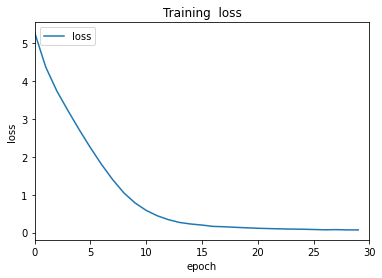

In [17]:
plt.plot(history.history['loss'])
plt.title('Training  loss')
plt.ylabel('loss')
plt.xlim([0, EPOCHS])
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

## テキストの生成

In [18]:
def generate_text(char_numb = 100, diversity=1.0):
  start_index = random.randint(0, len(text) - MAXLEN - 1)

  generated = ''
  sentence = text[start_index:start_index + MAXLEN]
  generated += sentence

  for i in range(char_numb):
    x_pred = np.zeros((1, MAXLEN, len(chars)))
    for t, char in enumerate(sentence):
      x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
  print()

In [19]:
generate_text(char_numb=100, diversity=0.2)

女が顔いなかっている事が……もがといた……いうしされど、ッにも引にぬく貴方あたの、、でああしかを今からこれたので、私はここになままった。こうにた。まになわれがした。ますがもこれでも何いかにもなないった


In [20]:
generate_text(char_numb=100, diversity=0.5)

な純のの人ので……」「………ら……と……お兄様……おにに妾をないましいうながらないくといっまといるうににタマ、一人もの壁ように……あ「されか来たいうしさ……声は、若林博士が、私が、そうして口のま前の上


In [21]:
generate_text(char_numb=100, diversity=1.0)

をを込まましく、た。これだもこがない持ぜしとなってお方にに……御御名前を経いにいですが……そのはその金の大身を見見るらなくを立下げべつのままころは……。私はもから笑いかいら笑いう無も、両」で大側の精神


In [22]:
generate_text(char_numb=100, diversity=1.2)

若若博博士れは正木先生がと、よでらものだ。アハハハハハ…。……。……と思うをポッと心ンチチ引ンいで……。……コにぬくヒ申して……と思うな身……御気がのさ。。重は分自分自過を見廻すらも真ななお縮却見にな


## 参考リンク
- https://keras.io/examples/lstm_text_generation/
- http://cedro3.com/ai/keras-lstm-text-word/
- https://deepage.net/deep_learning/2017/05/23/recurrent-neural-networks.html